In [21]:
import os
import re
import numpy as np
import pandas as pd
import pickle
import nltk
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)


True

# Data loading & setup

In [3]:
fake_news = pd.read_csv("data/Fake.csv")
true_news = pd.read_csv("data/True.csv")

fake_news["label"] = 0
true_news["label"] = 1

news = pd.concat([fake_news, true_news], axis=0)
news = news.sample(frac=1, random_state=42).reset_index(drop=True)
news = news.drop(["title", "subject", "date"], axis=1)

# Data cleaning and preprocessing
**By data preprocessing we mean removing the:**

**1. Stopwords (the, is, are…)**

**2. Punctuation, numbers, special symbols**

**3. Mixed cases (upper/lower)**

**4. Irrelevant whitespace**

**5. URLs**

**6. Stopwords removal (is, the, and, at, of)**

**7. Lemmatization: normalizes words so similar words count as one feature helpful in feature extraction (TF-IDF). EX: running -> run, better -> good, cars -> car**

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove emails
    text = re.sub(r'\S+@\S+', ' ', text)

    # Remove mentions (@username)
    text = re.sub(r'@\w+', ' ', text)

    # Remove hashtags (#topic)
    text = re.sub(r'#\w+', ' ', text)

    # Keep only alphabets (removes digits, punctuation, special chars, newline, etc.)
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization: Break the text into individual words (called tokens)
    tokens = word_tokenize(text)

    # Removing stopwords and Lemmatization (Convert each word to its root/base form)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

    # Join tokens back converting into a single string
    return " ".join(tokens)

In [6]:
news['text'] = news['text'].apply(preprocess_text)

# Feature Selection and Extraction
**for feature extraction we will use TF-IDF vectorizer(Term Frequency – Inverse Document Frequency.)**

**It’s a numerical statistic used in NLP to transform text into numbers so machine learning models can understand it.**

**TF-IDF turns text into useful numerical features by keeping important words and downplaying common ones → making it possible for ML models to detect fake vs real news.**

In [7]:
X = news['text']
y = news['label']

In [8]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [9]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [10]:
# Fit only on training data: vocabulary learned only from training data.
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform test data using the same vocabulary
X_test_tfidf = vectorizer.transform(X_test)

In [11]:
# To ensure X and y always match in size
assert X_train_tfidf.shape[0] == y_train.shape[0], "Train X/y shape mismatch"
assert X_test_tfidf.shape[0] == y_test.shape[0], "Test X/y shape mismatch"

# Model Training and Evaluation

**1. Logistic Regression Experiment**

In [12]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Predictions
y_prob_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

lr_thresholds = np.arange(0.1, 0.9, 0.05)
lr_results = []

# testing on diff thresholds
for t in lr_thresholds:
    preds = (y_prob_lr >= t).astype(int)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    lr_results.append((t, acc, f1))

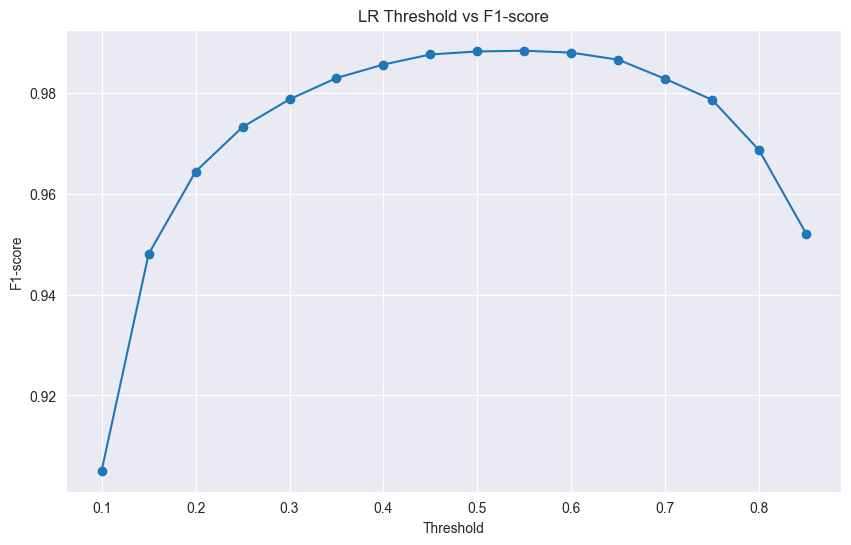

In [13]:
# Extract thresholds and F1-scores from your results list
lr_ths = [r[0] for r in lr_results]
lr_f1s = [r[2] for r in lr_results]

# plotting graph thresholds vs f1
plt.figure(figsize=(10,6))
plt.plot(lr_ths, lr_f1s, marker='o')
plt.title("LR Threshold vs F1-score")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.grid(True)
plt.show()

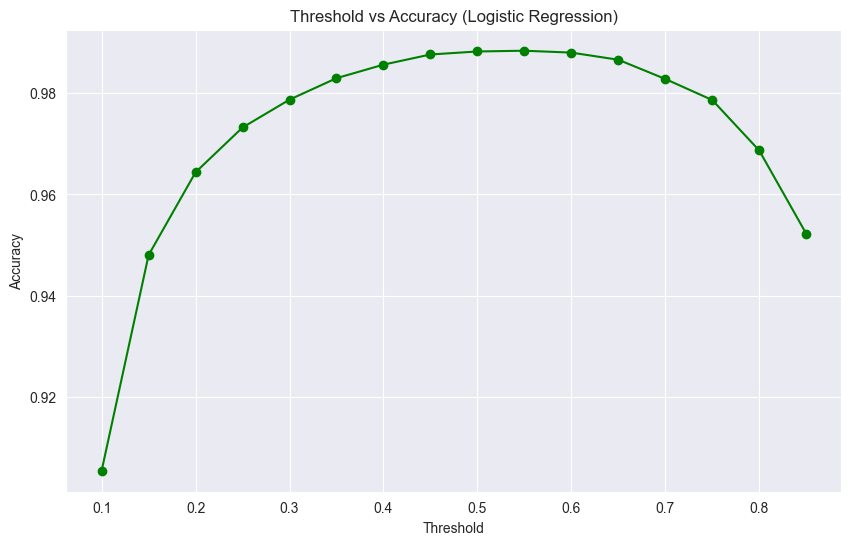

In [14]:
# Accuracy vs Threshold graph
lr_accs = [r[1] for r in lr_results]

plt.figure(figsize=(10,6))
plt.plot(lr_ths, lr_accs, marker='o', color='green')
plt.title("Threshold vs Accuracy (Logistic Regression)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [15]:
# Find threshold with best F1
best_lr_t, best_lr_acc, best_lr_f1 = max(lr_results, key=lambda x: x[2])

y_pred_lr_best = (y_prob_lr >= best_lr_t).astype(int)

**2. Naive Bayes Classifier**

In [16]:
# Train with Naive Bayes classifier

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_prob_nb = nb_model.predict_proba(X_test_tfidf)[:, 1]

nb_thresholds = np.arange(0.1, 0.9, 0.05)
nb_results = []

for t in nb_thresholds:
    preds = (y_prob_nb >= t).astype(int)
    acc = accuracy_score(y_test, preds)
    f1  = f1_score(y_test, preds, average='weighted')
    nb_results.append((t, acc, f1))

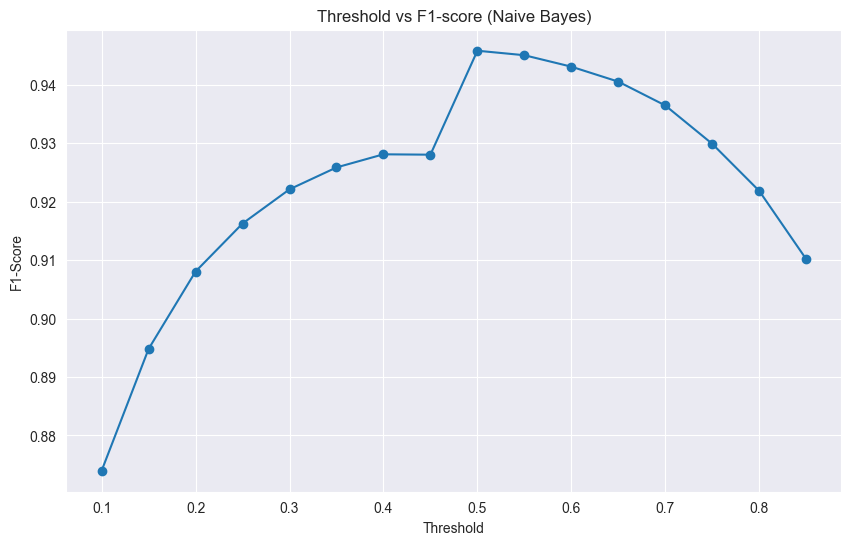

In [17]:
nb_ths = [r[0] for r in nb_results]
nb_f1s = [r[2] for r in nb_results]

plt.figure(figsize=(10,6))
plt.plot(nb_ths, nb_f1s, marker='o')
plt.title("Threshold vs F1-score (Naive Bayes)")
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.grid(True)
plt.show()

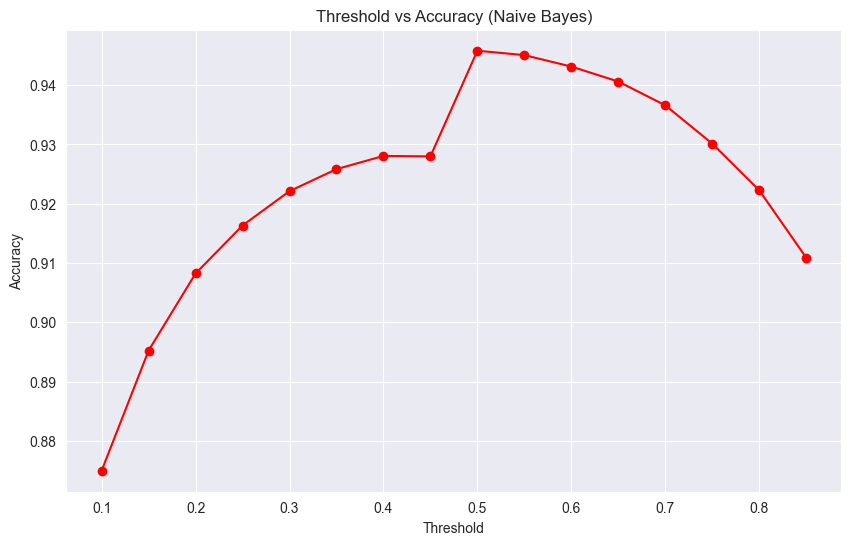

In [18]:
nb_accs = [r[1] for r in nb_results]

plt.figure(figsize=(10,6))
plt.plot(nb_ths, nb_accs, marker='o', color='red')
plt.title("Threshold vs Accuracy (Naive Bayes)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [19]:
best_nb_t, best_nb_acc, best_nb_f1 = max(nb_results, key=lambda x: x[2])

y_pred_nb_best = (y_prob_nb >= best_nb_t).astype(int)

In [20]:
results = {
    "lr_results": lr_results,
    "nb_results": nb_results,
    "best_lr": {
        "threshold": best_lr_t,
        "accuracy": best_lr_acc,
        "f1": best_lr_f1
    },
    "best_nb": {
        "threshold": best_nb_t,
        "accuracy": best_nb_acc,
        "f1": best_nb_f1
    },
    "y_test": y_test,
    "y_pred_lr_best": y_pred_lr_best,
    "y_pred_nb_best": y_pred_nb_best
}

os.makedirs("artifacts", exist_ok=True)
with open("artifacts/results.pkl", "wb") as f:
    pickle.dump(results, f)